# Mod 4 Project - Washington, DC Metro Area Housing data

This notebook uses house price data from Zillow.com.


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#for math and data structure
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error


#for modeling
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools

# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose as sd

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('2bedroom.csv', encoding='latin-1')
display(df.head())
df.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,242967.0,247021.0,249757.0,...,1275893,1270730,1269649,1275045,1275702,1273626,1267020,1270098,1270847,1264322
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,189749.0,189228.0,189955.0,...,404249,404260,403419,402173,401058,399323,397078,395128,393681,393083
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,NaN,NaN,NaN,...,1750642,1749422,1748443,1747668,1741497,1734066,1722324,1719511,1723527,1723346
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,NaN,NaN,NaN,...,260078,258859,257399,256848,257113,256780,256599,255876,255748,255021
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,204042.0,204116.0,205405.0,...,447670,448157,447446,446411,445575,443971,442062,440258,439023,437986


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26985 entries, 0 to 26984
Columns: 292 entries, RegionID to 2019-12
dtypes: float64(259), int64(29), object(4)
memory usage: 60.1+ MB


In [3]:
df.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12'],
      dtype='object', length=292)

# Step 2: Reshape from Wide to Long Format & Data Preprocessing

In [4]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [5]:
dfm = melt_data(df)
display(dfm.head())
dfm.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,1996-04-01,242967.0
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1996-04-01,189749.0
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,1996-04-01,204042.0
5,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,6,1996-04-01,67591.0
6,61616,10002,New York,NY,New York-Newark-Jersey City,New York County,7,1996-04-01,291024.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5565556 entries, 0 to 7690724
Data columns (total 9 columns):
RegionID      int64
RegionName    int64
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
Month         datetime64[ns]
MeanValue     float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 424.6+ MB


### Step 2b: Selecting a region for investigation

Region = Washington, DC

In [6]:
DC = dfm[(dfm.Metro == 'Washington-Arlington-Alexandria')
          & (dfm.CountyName.isin(['District of Columbia','Arlington']))].copy()
DC.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
30,66126,20002,Washington,DC,Washington-Arlington-Alexandria,District of Columbia,31,1996-04-01,139104.0
44,66133,20009,Washington,DC,Washington-Arlington-Alexandria,District of Columbia,45,1996-04-01,173195.0
204,66135,20011,Washington,DC,Washington-Arlington-Alexandria,District of Columbia,205,1996-04-01,155958.0
237,66125,20001,Washington,DC,Washington-Arlington-Alexandria,District of Columbia,238,1996-04-01,140695.0
321,66142,20019,Washington,DC,Washington-Arlington-Alexandria,District of Columbia,322,1996-04-01,85829.0


In [7]:
# Remove columns which are not helpful for data analysis
DC.drop(['RegionID','City','State','Metro','CountyName','SizeRank'], axis=1, inplace=True)
DC.reset_index(drop=True, inplace=True)
DC.head()

,RegionName,Month,MeanValue
0,20002,1996-04-01,139104.0
1,20009,1996-04-01,173195.0
2,20011,1996-04-01,155958.0
3,20001,1996-04-01,140695.0
4,20019,1996-04-01,85829.0


In [8]:
# See if any zipcodes are lacking observations
print(len(DC.RegionName.unique()))
DC.RegionName.value_counts()[-7:]

22


20007    285
20011    285
20015    285
20019    285
20002    285
20001    285
20006     92
Name: RegionName, dtype: int64

# Step 3: EDA and Visualization

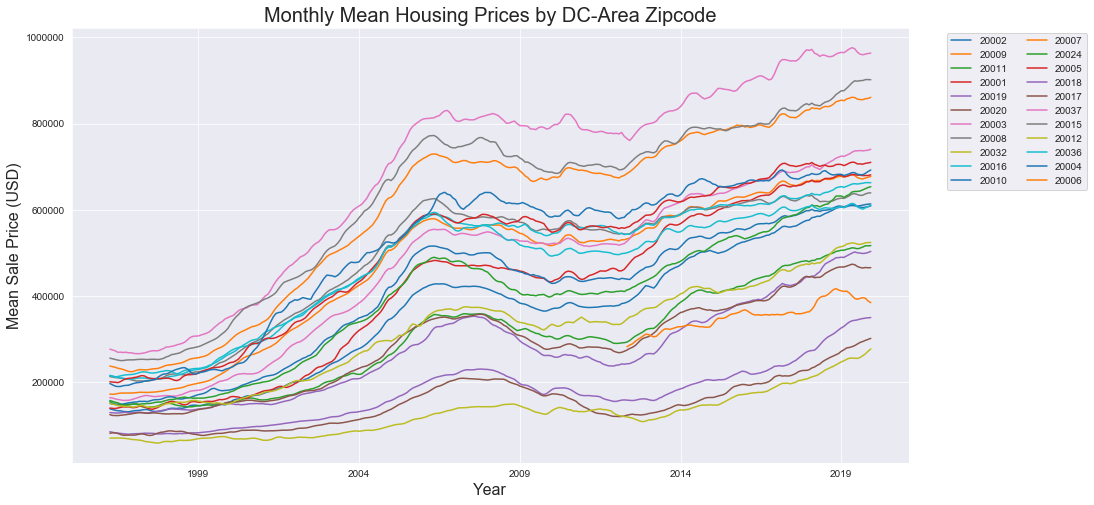

In [9]:
for zipcode in DC.RegionName.unique():
    temp_df = DC[DC.RegionName == zipcode].set_index('Month')
    temp_df['MeanValue'].plot(figsize=(15,8), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16)
plt.title("Monthly Mean Housing Prices by DC-Area Zipcode", fontsize=20);

Wonderful! It appears that each of the Atlanta zipcodes is capable of being plotted without throwing any errors.

#### Removing potentially confounding data

Looking at the graph above and thinking about recent history, we know that the housing crash of 2008 is the culprit behind the dip in housing price in the middle of our graph. Because we want to make business decisions based on post-crash trends. Therefore, we will build our models using only the data gathered after 2010 (2011-present) since this was when the housing market bottomed out. 

In [10]:
DC2 = DC[DC.Month >= '2012']

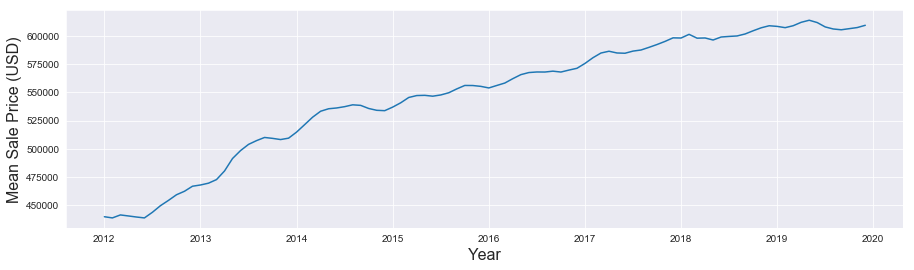

In [11]:
# Plot an example zipcode, to test outcome
temp_df = DC2[DC2.RegionName == 20010].set_index('Month')
temp_df['MeanValue'].plot(figsize=(15,4), label=20010)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16);

# Step 4: ARIMA Modeling

Region: Washington, DC

Best = Highest ROI with the lowest volatility since 2010 (after housing crash)

In [12]:
# Make a dictionary for each zipcode
washington = {}
for zipcode in DC2.RegionName.unique():
    temp = DC2[DC2.RegionName == zipcode].set_index('Month')
    temp.drop('RegionName', axis=1, inplace=True)
    washington[zipcode] = temp

In [13]:
# Log transform the values
DC_log ={}
for zipcode in washington.keys():
    DC_log[zipcode] = np.log(washington[zipcode])

In [14]:
# Differencing the log-transformed values
DC_log_diff = {}
for key in list(washington.keys()):
    DC_log_diff[key] = DC_log[key].diff(periods=12).dropna()

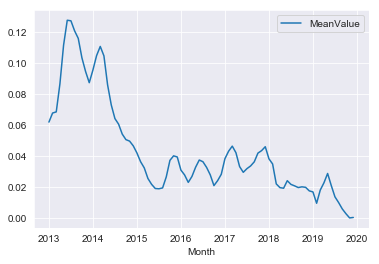

In [15]:
DC_log_diff[20010].plot();

In [16]:
# Define a function that will check for the stationarity of a time series
def stationarity_check(TS, column_name, rolling_window=7):    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = rolling_window, center = False).mean()
    rolstd = TS.rolling(window = rolling_window, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column_name]) 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    pass

In [17]:
# Define a function to decompose a time series, in order to detect
# trends and seasonality, and allow for examining the residuals
def df_decompose(df):
    # Gather the trend, seasonality and noise of decomposed object
    trend = sd(df).trend
    seasonal = sd(df).seasonal
    residual = sd(df).resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.title(f"Decomposition for {df}")
    plt.subplot(411)
    plt.plot(df, label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout();
    
    return residual.dropna()

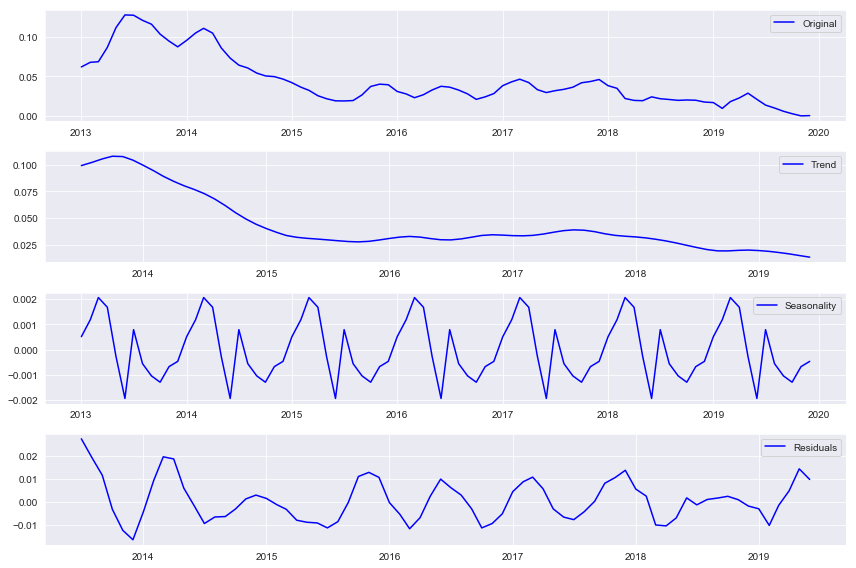

In [18]:
decomp20010 = df_decompose(DC_log_diff[20010])

Looking at the y-axis of the seasonality plot, it appears that there is **very** little seasonality. So little, in fact, that we can most likely assume that seasonality is not a feature of our data.

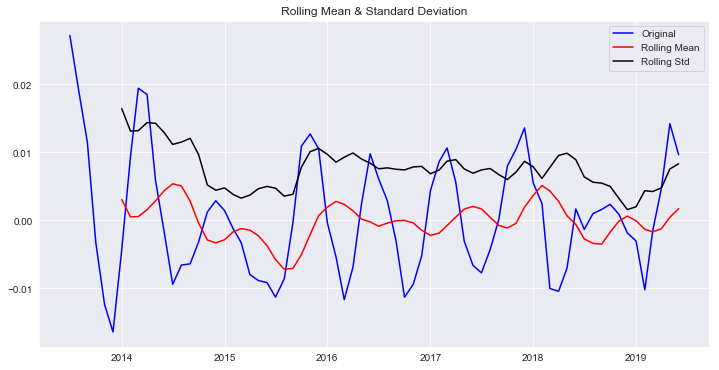

Results of Dickey-Fuller Test:
Test Statistic                 -2.662639
p-value                         0.080730
#Lags Used                      8.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [19]:
stationarity_check(decomp20010,'MeanValue')

**Our data appears to be stationary!**

### Let's try using sARIMAX without seasonality

In [20]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

In [21]:
def find_best_pdq(df, label, pdq):
    """
    Input a dataframe and lists of potential pdq & pdqs values
    Finds combination of pdq/pdqs values that returns lowest AIC
    Returns tuple of label, pdq, and pdqs
    """
    import warnings
    warnings.filterwarnings('ignore')
    
    results = []
    for params in pdq:
        try:
            model = SARIMAX(endog=df, order=params,
#                                 seasonal_order=seas_params,
                            enforce_stationarity=False, enforce_invertibility=False)
            AIC = model.fit().aic
#             print(f'ARIMA{params}x{seas_params}12 - AIC: {AIC}')
            results.append([params, AIC])
        except:
            continue

    results.sort(key=lambda x: x[-1])
    result_pdq = results[0][0]
#     print(f'Lowest AIC: ARIMA{result_pdq} - AIC: {results[0][1]}')
    return (label, result_pdq)

In [22]:
pdq20010 = find_best_pdq(DC_log[20010], 20010, pdq)

In [23]:
pdq20010

(20010, (1, 0, 2))

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 402.232
Date:                Sun, 02 Feb 2020   AIC                           -796.464
Time:                        14:46:20   BIC                           -786.333
Sample:                    01-01-2012   HQIC                          -792.373
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0003   6.22e-05   1.61e+04      0.000       1.000       1.000
ma.L1          0.7824      0.086      9.051      0.000       0.613       0.952
ma.L2          0.6825      0.108      6.313      0.000       0.471       0.894
sigma2      1.006e-05   1.45e-06      6.927      0.000    7.21e-06    1.29e-05
===================================================================================
Ljung-Box (Q):                       31.98   Jarque-Bera (JB):                 8.57
Prob(Q):                              0.81   Prob(JB):                         0.01
Heteroskedasticity (H):               0.48   Skew:                             0.48
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

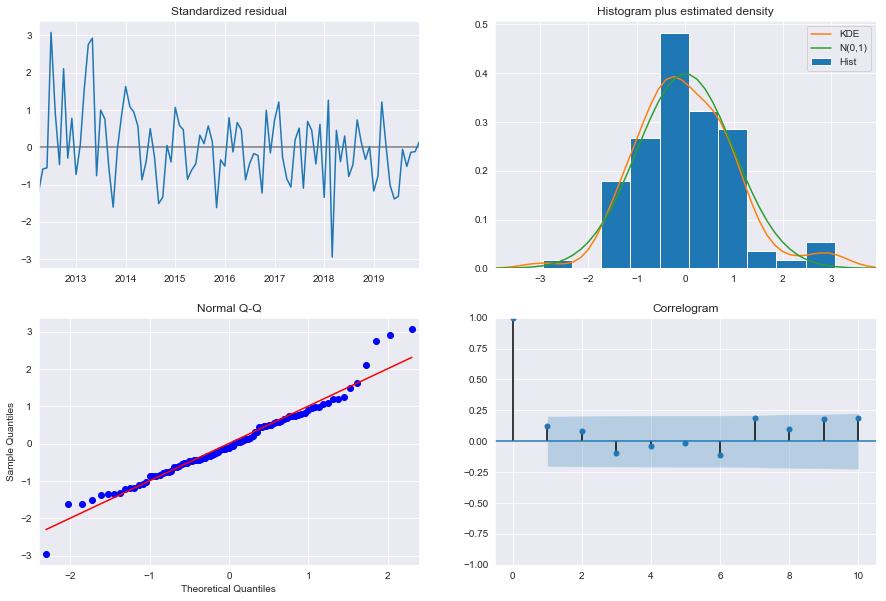

In [24]:
# plug the optimal parameter values into a new SARIMAX model.
mod_SARIMAX = SARIMAX(endog=DC_log[20010], order=pdq20010[1],
                            enforce_stationarity=False, enforce_invertibility=False)

# Fit the model and print results
res_SARIMAX = mod_SARIMAX.fit()
display(res_SARIMAX.summary())
res_SARIMAX.plot_diagnostics(figsize=(15,10));

In [25]:
# Get predictions starting from 2016 and calculate confidence intervals.
prediction = res_SARIMAX.get_prediction(start=pd.to_datetime('2016-04'), dynamic=True)
pred_conf = prediction.conf_int()

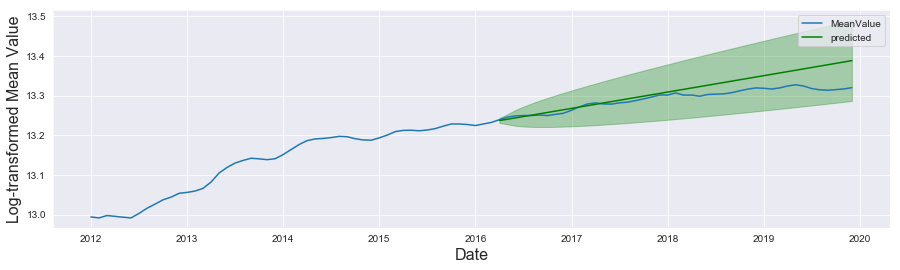

In [26]:
# Plot observed values
DC_log[20010]['2012':].plot(label='observed')

# Plot predicted values
prediction.predicted_mean.plot(figsize=(15,4),color='g', label='predicted')

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.3)

# Set axes labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Log-transformed Mean Value', fontsize=16)
plt.legend();

In [27]:
# Get the Real and predicted values
DC20010_truth = DC_log[20010]['2016-04':]
DC20010_forecasted = prediction.predicted_mean

# Compute the mean square error
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(DC20010_truth, DC20010_forecasted))
print(f'The Root Mean Squared Error of our forecasts is {round(rmse, 3)}')

The Root Mean Squared Error of our forecasts is 0.03


### Now iterate through all selected zipcodes

In [28]:
def plot_predictions(df, label, prediction, pred_conf, best_pdq):
    """Inputs: dataframe, zipcode label, predictions, prediction confidence
    intervals, and optimal (p,d,q) parameters
    -------------------
    This function plots a time series, a predicted mean line, and prediction
    confidence intervals.
    """
    # Plot observed values
    np.exp(df['2012':]).plot(label='observed')
    
    # Plot predicted values
    pred_price = np.exp(prediction.predicted_mean)
    pred_price.plot(figsize=(15,4),color='g', label='predicted')
    
    # Plot the range for confidence intervals
    pred_conf_usd = np.exp(pred_conf)
    plt.fill_between(pred_conf_usd.index,
                    pred_conf_usd.iloc[:, 0],
                    pred_conf_usd.iloc[:, 1], color='g', alpha=.3)
    
    # Set axes labels
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mean Value', fontsize=14)
    plt.title(f"{label} Zipcode; pdq={best_pdq}", fontsize=16)
    plt.legend(loc='best', fontsize=14)
    plt.show();


def expected_roi(investment, final_value):
    """This function takes in a series of forecasts to predict the return
    on investment spanning the entire forecast."""
    roi = ((final_value - investment) / investment)
    return roi


def confidence_score(pred_conf):
    """This function takes in a prediction's confidence interval
    and calculates the difference between the upper and lower bounds at the
    greatest X value as a proportion of the upper bound maximum. The purpose 
    is to provide a metric by which to compare model according to their variability.
    A model with more uncertainty will have a lower confidence score.
    -----------------------
    Since I pretty much made this up, I'm calling it the Parker Confidence Score (PCS)."""
    pred_conf_usd = np.exp(pred_conf)    #reversing log-transformation
    conf_score = 1 - ((pred_conf_usd['upper MeanValue'][-1]
                       - pred_conf_usd['lower MeanValue'][-1])
                      / pred_conf_usd['upper MeanValue'][-1])
    return conf_score


def make_best_Arima_model(df, label, pdq):
    """
    Inputs: a dataframe, the zipcode label, and list of (p,d,q) combinations.
    ------------------------
    The function calculates the optimal (p,d,q), then creates a dynamic SARIMAX
    model with those paramters. The model then makes predictions and, if the lower
    bound of the confidence interval is greater than the prediction starting point
    (i.e. guarantee of profit), the model calcules RMSE, ROI, and a Confidence
    Score. 
    ------------------------
    Returns: label, optimal (p,d,q) parameters, SARIMAX model  object, RMSE,
    ROI, and Confidence Score
    """
    import warnings
    warnings.filterwarnings('ignore')
    
    result_pdq = find_best_pdq(df, label, pdq)
    
    # plug the optimal parameter values into a new SARIMAX model.
    mod_SARIMAX = SARIMAX(endog=df, order=result_pdq[1],
                                enforce_stationarity=False, enforce_invertibility=False)
    
    # Fit the model and print results
    res_SARIMAX = mod_SARIMAX.fit()
    
    # Get predictions starting from 2016 and calculate confidence intervals.
    prediction = res_SARIMAX.get_prediction(start=pd.to_datetime('2016-04'), dynamic=True)
    pred_conf = prediction.conf_int()
    rmse = 0
    roi = 0
    conf_score = 0
    if pred_conf['lower MeanValue'][-1] > pred_conf['lower MeanValue'][0]:
        print("\n\nZipcode:", label)
        
        # Get the Real and predicted values
        df_truth = np.exp(df['2016-04':])
        df_forecasted = np.exp(prediction.predicted_mean)
        
        # Compute the mean square error & volatility
        rmse = np.sqrt(mean_squared_error(df_truth, df_forecasted))
        print(f'Root Mean Squared Error of forecast: {round(rmse, 3)}')
        conf_score = np.round(confidence_score(pred_conf), 4)
        print(f'Parker Confidence Score: {conf_score}')
        
        #Expected 2-year return on investment
        roi = np.round(expected_roi(df_forecasted[0], df_forecasted[-1]),4)
        print(f"Model 2-yr expected ROI rate: {roi*100}%")
        
        # Plot observed & predicted values with confidence interval
        plot_predictions(df, label, prediction, pred_conf, result_pdq[1]);
    
    return label, result_pdq[1], res_SARIMAX, rmse, roi, conf_score

#### WARNING:

The next cell may take several minutes to run.



Zipcode: 20002
Root Mean Squared Error of forecast: 21596.601
Parker Confidence Score: 0.7923
Model 2-yr expected ROI rate: 24.51%


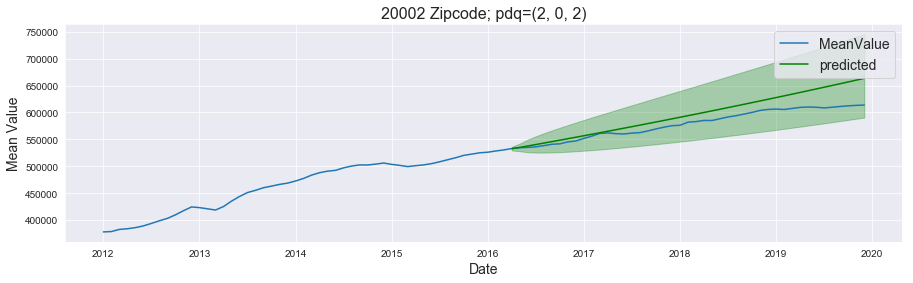



Zipcode: 20009
Root Mean Squared Error of forecast: 14952.882
Parker Confidence Score: 0.841
Model 2-yr expected ROI rate: 11.76%


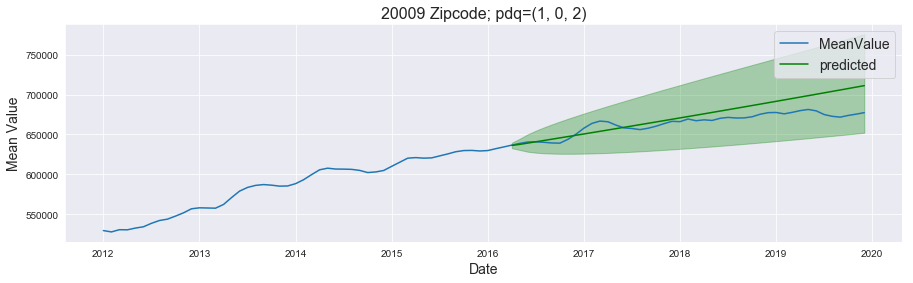



Zipcode: 20011
Root Mean Squared Error of forecast: 9529.767
Parker Confidence Score: 0.7948
Model 2-yr expected ROI rate: 15.920000000000002%


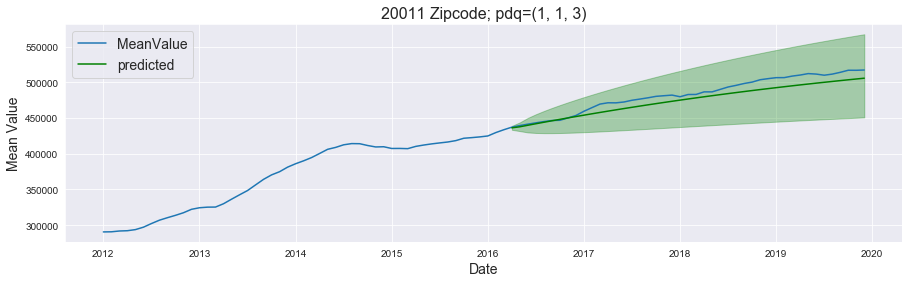



Zipcode: 20001
Root Mean Squared Error of forecast: 30358.985
Parker Confidence Score: 0.8189
Model 2-yr expected ROI rate: 19.950000000000003%


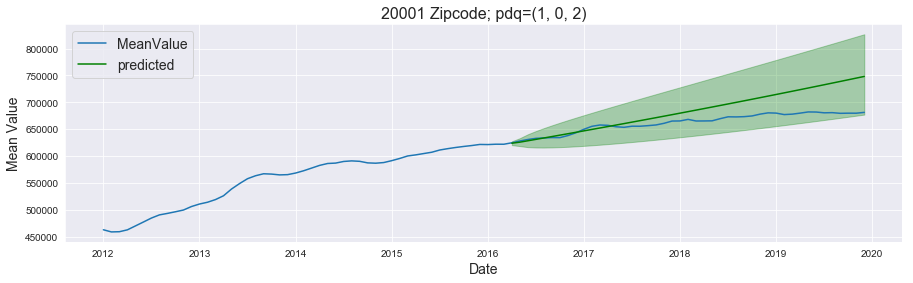



Zipcode: 20019
Root Mean Squared Error of forecast: 24803.273
Parker Confidence Score: 0.7134
Model 2-yr expected ROI rate: 44.21%


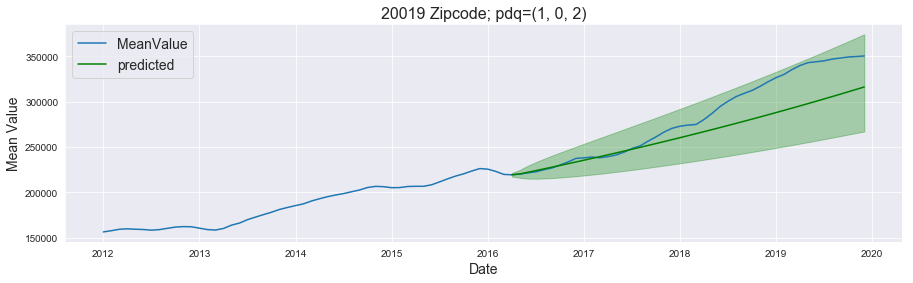



Zipcode: 20020
Root Mean Squared Error of forecast: 4655.278
Parker Confidence Score: 0.6809
Model 2-yr expected ROI rate: 54.22%


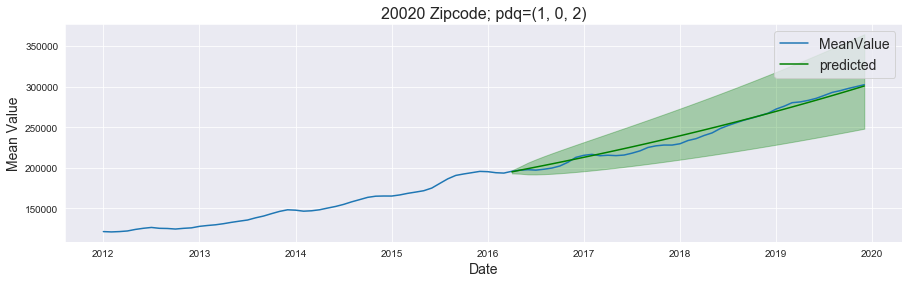



Zipcode: 20003
Root Mean Squared Error of forecast: 23868.792
Parker Confidence Score: 0.8285
Model 2-yr expected ROI rate: 17.82%


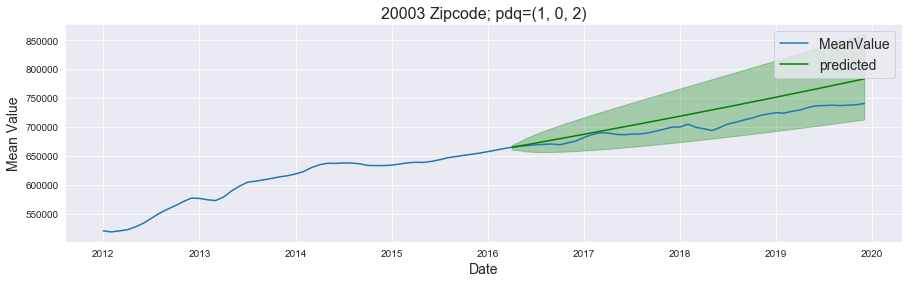



Zipcode: 20032
Root Mean Squared Error of forecast: 7237.695
Parker Confidence Score: 0.6457
Model 2-yr expected ROI rate: 47.82%


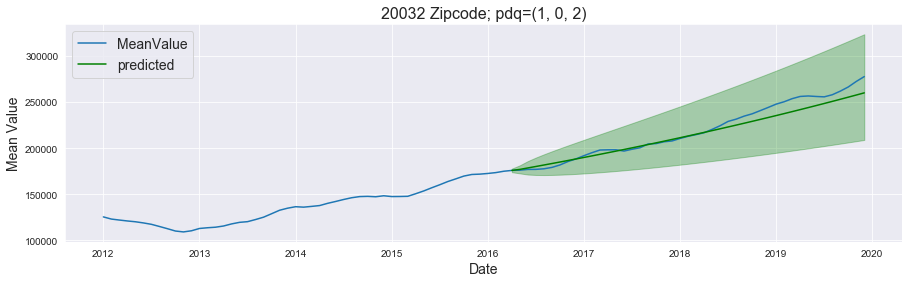



Zipcode: 20016
Root Mean Squared Error of forecast: 3781.792
Parker Confidence Score: 0.8967
Model 2-yr expected ROI rate: 9.64%


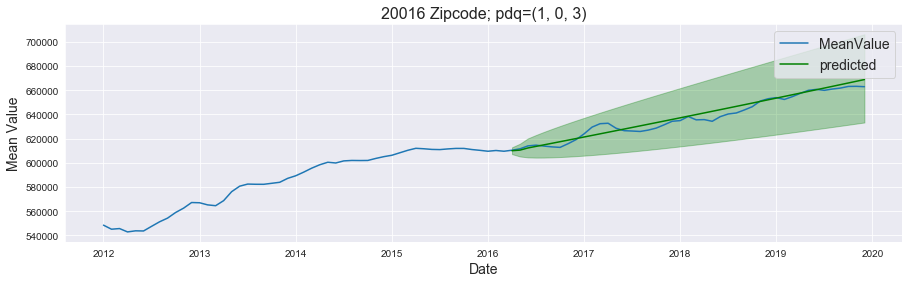



Zipcode: 20010
Root Mean Squared Error of forecast: 18456.457
Parker Confidence Score: 0.8157
Model 2-yr expected ROI rate: 16.3%


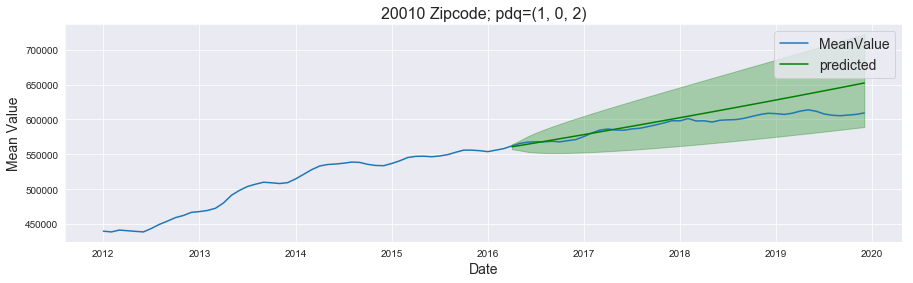



Zipcode: 20007
Root Mean Squared Error of forecast: 8648.966
Parker Confidence Score: 0.8596
Model 2-yr expected ROI rate: 11.4%


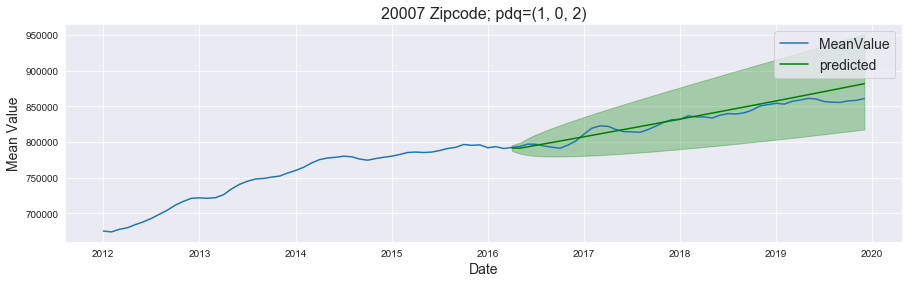



Zipcode: 20024
Root Mean Squared Error of forecast: 8272.316
Parker Confidence Score: 0.8438
Model 2-yr expected ROI rate: 24.610000000000003%


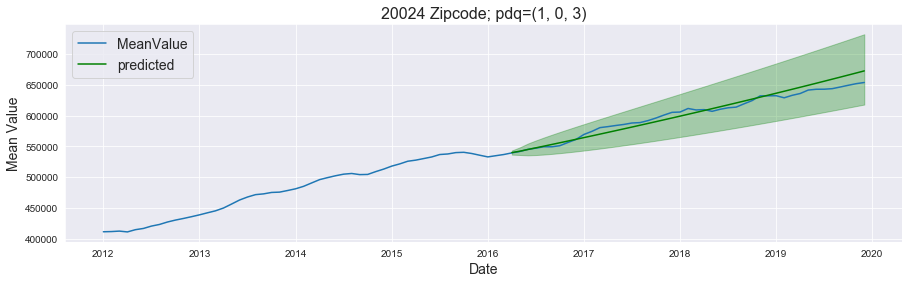



Zipcode: 20005
Root Mean Squared Error of forecast: 15341.208
Parker Confidence Score: 0.8403
Model 2-yr expected ROI rate: 11.43%


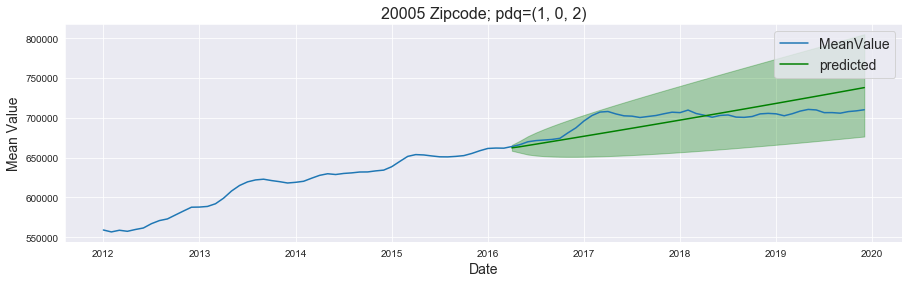



Zipcode: 20018
Root Mean Squared Error of forecast: 16983.967
Parker Confidence Score: 0.7241
Model 2-yr expected ROI rate: 40.52%


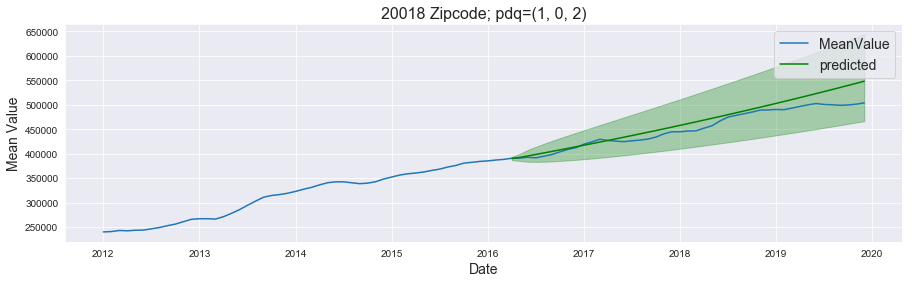



Zipcode: 20017
Root Mean Squared Error of forecast: 11485.72
Parker Confidence Score: 0.7679
Model 2-yr expected ROI rate: 29.310000000000002%


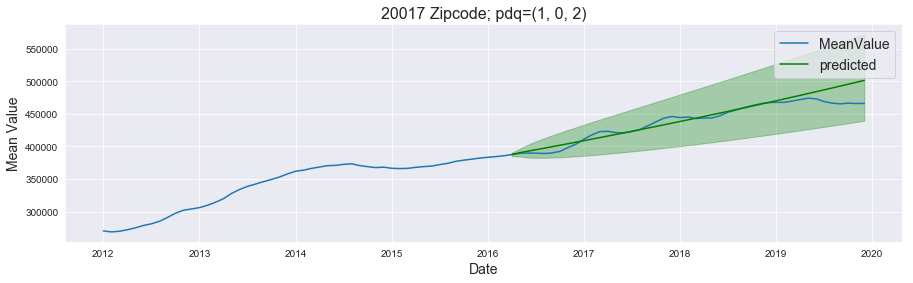



Zipcode: 20015
Root Mean Squared Error of forecast: 9047.283
Parker Confidence Score: 0.8432
Model 2-yr expected ROI rate: 12.629999999999999%


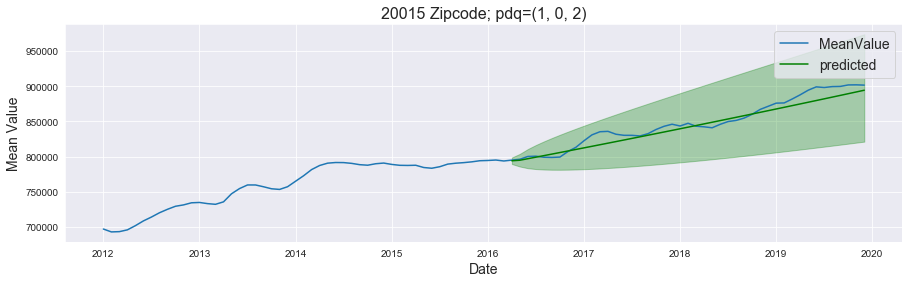



Zipcode: 20012
Root Mean Squared Error of forecast: 11933.448
Parker Confidence Score: 0.7664
Model 2-yr expected ROI rate: 22.85%


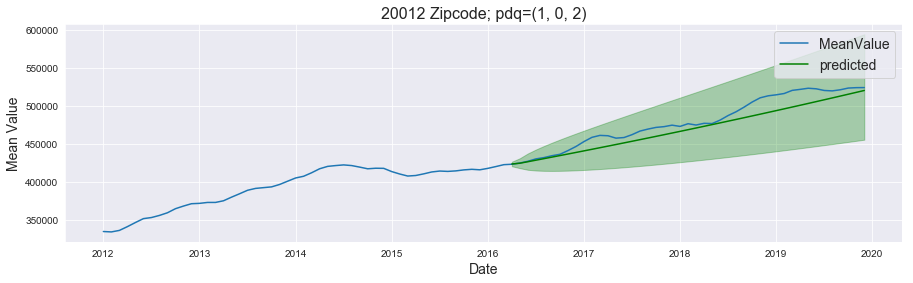



Zipcode: 20036
Root Mean Squared Error of forecast: 17008.475
Parker Confidence Score: 0.8261
Model 2-yr expected ROI rate: 9.75%


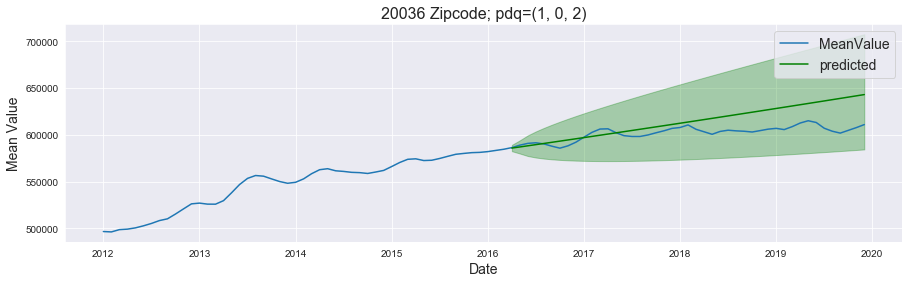

In [29]:
DC_arima_models = []
for zipcode in list(DC_log.keys())[:]:
    model = make_best_Arima_model(DC_log[zipcode], zipcode, pdq)
    DC_arima_models.append(model)

In [30]:
# Sort the output according to highest model confidence score
sorted_list = sorted(DC_arima_models, key=lambda x: (x[-1], x[-2]), reverse=True)
for x in sorted_list:
    print(f"Zipcode:\t{x[0]}\nRMSE:\t\t{x[3]}\nROI:\t\t{x[-2]}\nConf. Score:\t{x[-1]}\n")

Zipcode:	20016
RMSE:		3781.7922422422344
ROI:		0.0964
Conf. Score:	0.8967

Zipcode:	20007
RMSE:		8648.966151932314
ROI:		0.114
Conf. Score:	0.8596

Zipcode:	20024
RMSE:		8272.316321872138
ROI:		0.2461
Conf. Score:	0.8438

Zipcode:	20015
RMSE:		9047.28273684661
ROI:		0.1263
Conf. Score:	0.8432

Zipcode:	20009
RMSE:		14952.881636937434
ROI:		0.1176
Conf. Score:	0.841

Zipcode:	20005
RMSE:		15341.207740948563
ROI:		0.1143
Conf. Score:	0.8403

Zipcode:	20003
RMSE:		23868.791576793035
ROI:		0.1782
Conf. Score:	0.8285

Zipcode:	20036
RMSE:		17008.475350192883
ROI:		0.0975
Conf. Score:	0.8261

Zipcode:	20001
RMSE:		30358.985472518416
ROI:		0.1995
Conf. Score:	0.8189

Zipcode:	20010
RMSE:		18456.45693614017
ROI:		0.163
Conf. Score:	0.8157

Zipcode:	20011
RMSE:		9529.766637604287
ROI:		0.1592
Conf. Score:	0.7948

Zipcode:	20002
RMSE:		21596.601178512683
ROI:		0.2451
Conf. Score:	0.7923

Zipcode:	20017
RMSE:		11485.720077827062
ROI:		0.2931
Conf. Score:	0.7679

Zipcode:	20012
RMSE:		11933.448137

In [36]:
# Filtering for models with confidence score > .8
best_conf = []
for x in sorted_list:
    if x[-1] > .8:
        best_conf.append(x)

# From these models, select the top five ROI
top_five = sorted(best_conf, key=lambda x: x[-2], reverse=True)[:10]
for x in top_five:
    print(f"Zipcode:\t{x[0]}\nRMSE:\t\t${round(x[3],2)}\nROI:\t\t{x[-2]}\nConf. Score:\t{x[-1]}\n")

Zipcode:	20024
RMSE:		$8272.32
ROI:		0.2461
Conf. Score:	0.8438

Zipcode:	20001
RMSE:		$30358.99
ROI:		0.1995
Conf. Score:	0.8189

Zipcode:	20003
RMSE:		$23868.79
ROI:		0.1782
Conf. Score:	0.8285

Zipcode:	20010
RMSE:		$18456.46
ROI:		0.163
Conf. Score:	0.8157

Zipcode:	20015
RMSE:		$9047.28
ROI:		0.1263
Conf. Score:	0.8432

Zipcode:	20009
RMSE:		$14952.88
ROI:		0.1176
Conf. Score:	0.841

Zipcode:	20005
RMSE:		$15341.21
ROI:		0.1143
Conf. Score:	0.8403

Zipcode:	20007
RMSE:		$8648.97
ROI:		0.114
Conf. Score:	0.8596

Zipcode:	20036
RMSE:		$17008.48
ROI:		0.0975
Conf. Score:	0.8261

Zipcode:	20016
RMSE:		$3781.79
ROI:		0.0964
Conf. Score:	0.8967



#### Now examine the model summaries, just to make sure there is nothing problematic occurring behind the scenes.


Zipcode: 	20024


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 397.507
Date:                Sun, 02 Feb 2020   AIC                           -785.013
Time:                        14:57:27   BIC                           -772.405
Sample:                    01-01-2012   HQIC                          -779.924
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0004   5.25e-05   1.91e+04      0.000       1.000       1.000
ma.L1          0.5351      0.094      5.668      0.000       0.350       0.720
ma.L2          0.5978      0.112      5.352      0.000       0.379       0.817
ma.L3         -0.1007      0.106     -0.948      0.343      -0.309       0.107
sigma2      1.018e-05   1.55e-06      6.548      0.000    7.13e-06    1.32e-05
===================================================================================
Ljung-Box (Q):                       46.78   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.21   Prob(JB):                         0.39
Heteroskedasticity (H):               1.36   Skew:                            -0.29
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Zipcode: 	20001


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 410.253
Date:                Sun, 02 Feb 2020   AIC                           -812.506
Time:                        14:57:27   BIC                           -802.376
Sample:                    01-01-2012   HQIC                          -808.416
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0003   6.23e-05   1.61e+04      0.000       1.000       1.000
ma.L1          0.8205      0.090      9.148      0.000       0.645       0.996
ma.L2          0.8251      0.095      8.720      0.000       0.640       1.011
sigma2      8.392e-06   1.16e-06      7.217      0.000    6.11e-06    1.07e-05
===================================================================================
Ljung-Box (Q):                       44.01   Jarque-Bera (JB):                 9.24
Prob(Q):                              0.31   Prob(JB):                         0.01
Heteroskedasticity (H):               0.45   Skew:                             0.45
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Zipcode: 	20003


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 407.554
Date:                Sun, 02 Feb 2020   AIC                           -807.109
Time:                        14:57:27   BIC                           -796.978
Sample:                    01-01-2012   HQIC                          -803.018
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0003   6.13e-05   1.63e+04      0.000       1.000       1.000
ma.L1          0.7541      0.105      7.179      0.000       0.548       0.960
ma.L2          0.6541      0.120      5.448      0.000       0.419       0.889
sigma2      8.983e-06   9.85e-07      9.120      0.000    7.05e-06    1.09e-05
===================================================================================
Ljung-Box (Q):                       33.30   Jarque-Bera (JB):                40.37
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.43
Prob(H) (two-sided):                  0.34   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Zipcode: 	20010


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 402.232
Date:                Sun, 02 Feb 2020   AIC                           -796.464
Time:                        14:57:27   BIC                           -786.333
Sample:                    01-01-2012   HQIC                          -792.373
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0003   6.22e-05   1.61e+04      0.000       1.000       1.000
ma.L1          0.7824      0.086      9.051      0.000       0.613       0.952
ma.L2          0.6825      0.108      6.313      0.000       0.471       0.894
sigma2      1.006e-05   1.45e-06      6.927      0.000    7.21e-06    1.29e-05
===================================================================================
Ljung-Box (Q):                       31.98   Jarque-Bera (JB):                 8.57
Prob(Q):                              0.81   Prob(JB):                         0.01
Heteroskedasticity (H):               0.48   Skew:                             0.48
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Zipcode: 	20015


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 408.837
Date:                Sun, 02 Feb 2020   AIC                           -809.674
Time:                        14:57:27   BIC                           -799.544
Sample:                    01-01-2012   HQIC                          -805.584
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0002   5.25e-05    1.9e+04      0.000       1.000       1.000
ma.L1          0.6775      0.104      6.507      0.000       0.473       0.882
ma.L2          0.5381      0.135      3.989      0.000       0.274       0.802
sigma2      8.727e-06   1.47e-06      5.918      0.000    5.84e-06    1.16e-05
===================================================================================
Ljung-Box (Q):                       54.56   Jarque-Bera (JB):                 3.44
Prob(Q):                              0.06   Prob(JB):                         0.18
Heteroskedasticity (H):               0.87   Skew:                             0.32
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Zipcode: 	20009


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 416.405
Date:                Sun, 02 Feb 2020   AIC                           -824.810
Time:                        14:57:27   BIC                           -814.680
Sample:                    01-01-2012   HQIC                          -820.720
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0002   5.31e-05   1.88e+04      0.000       1.000       1.000
ma.L1          0.8139      0.085      9.531      0.000       0.647       0.981
ma.L2          0.6190      0.116      5.337      0.000       0.392       0.846
sigma2      7.473e-06   1.16e-06      6.421      0.000    5.19e-06    9.75e-06
===================================================================================
Ljung-Box (Q):                       58.41   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.03   Prob(JB):                         0.58
Heteroskedasticity (H):               0.74   Skew:                             0.26
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Zipcode: 	20005


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 412.309
Date:                Sun, 02 Feb 2020   AIC                           -816.617
Time:                        14:57:27   BIC                           -806.487
Sample:                    01-01-2012   HQIC                          -812.527
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0002   5.13e-05   1.95e+04      0.000       1.000       1.000
ma.L1          0.7503      0.104      7.217      0.000       0.547       0.954
ma.L2          0.5951      0.130      4.583      0.000       0.341       0.850
sigma2      8.122e-06   1.28e-06      6.326      0.000    5.61e-06    1.06e-05
===================================================================================
Ljung-Box (Q):                       31.87   Jarque-Bera (JB):                 2.79
Prob(Q):                              0.82   Prob(JB):                         0.25
Heteroskedasticity (H):               0.95   Skew:                             0.15
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Zipcode: 	20007


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 421.618
Date:                Sun, 02 Feb 2020   AIC                           -835.236
Time:                        14:57:27   BIC                           -825.105
Sample:                    01-01-2012   HQIC                          -831.145
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0002   4.49e-05   2.23e+04      0.000       1.000       1.000
ma.L1          0.6358      0.093      6.867      0.000       0.454       0.817
ma.L2          0.6145      0.109      5.634      0.000       0.401       0.828
sigma2      6.671e-06   1.28e-06      5.222      0.000    4.17e-06    9.18e-06
===================================================================================
Ljung-Box (Q):                       57.31   Jarque-Bera (JB):                 2.01
Prob(Q):                              0.04   Prob(JB):                         0.37
Heteroskedasticity (H):               1.09   Skew:                            -0.16
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Zipcode: 	20036


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 409.731
Date:                Sun, 02 Feb 2020   AIC                           -811.461
Time:                        14:57:27   BIC                           -801.331
Sample:                    01-01-2012   HQIC                          -807.371
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0002   5.94e-05   1.68e+04      0.000       1.000       1.000
ma.L1          0.8488      0.106      8.012      0.000       0.641       1.056
ma.L2          0.6637      0.101      6.563      0.000       0.466       0.862
sigma2      8.552e-06   9.78e-07      8.741      0.000    6.63e-06    1.05e-05
===================================================================================
Ljung-Box (Q):                       91.23   Jarque-Bera (JB):                11.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.20
Prob(H) (two-sided):                  0.84   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Zipcode: 	20016


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   96
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 425.431
Date:                Sun, 02 Feb 2020   AIC                           -840.863
Time:                        14:57:27   BIC                           -828.254
Sample:                    01-01-2012   HQIC                          -835.774
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0002   3.49e-05   2.87e+04      0.000       1.000       1.000
ma.L1          0.5973      0.107      5.605      0.000       0.388       0.806
ma.L2          0.4741      0.123      3.851      0.000       0.233       0.715
ma.L3         -0.2973      0.118     -2.519      0.012      -0.529      -0.066
sigma2      5.485e-06   8.19e-07      6.701      0.000    3.88e-06    7.09e-06
===================================================================================
Ljung-Box (Q):                       35.37   Jarque-Bera (JB):                 3.60
Prob(Q):                              0.68   Prob(JB):                         0.16
Heteroskedasticity (H):               0.68   Skew:                             0.36
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

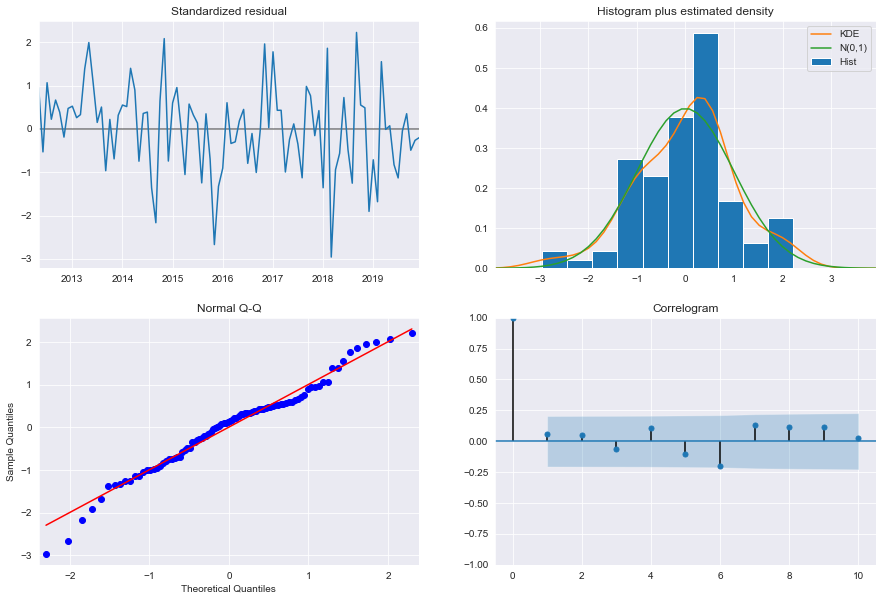

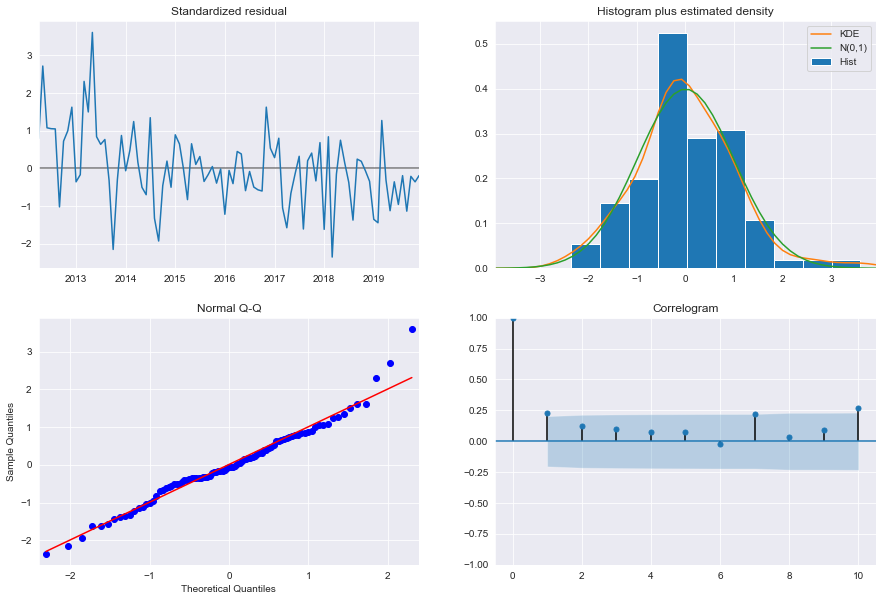

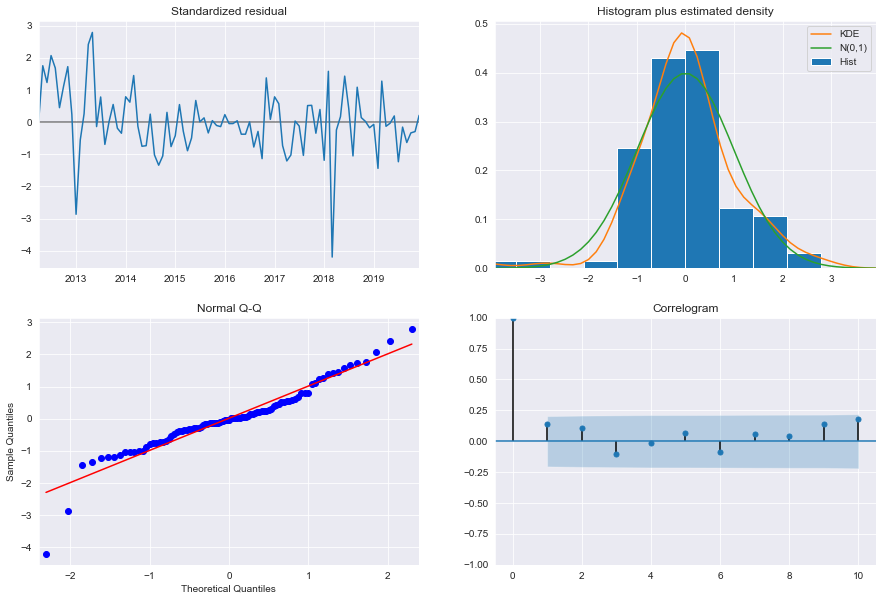

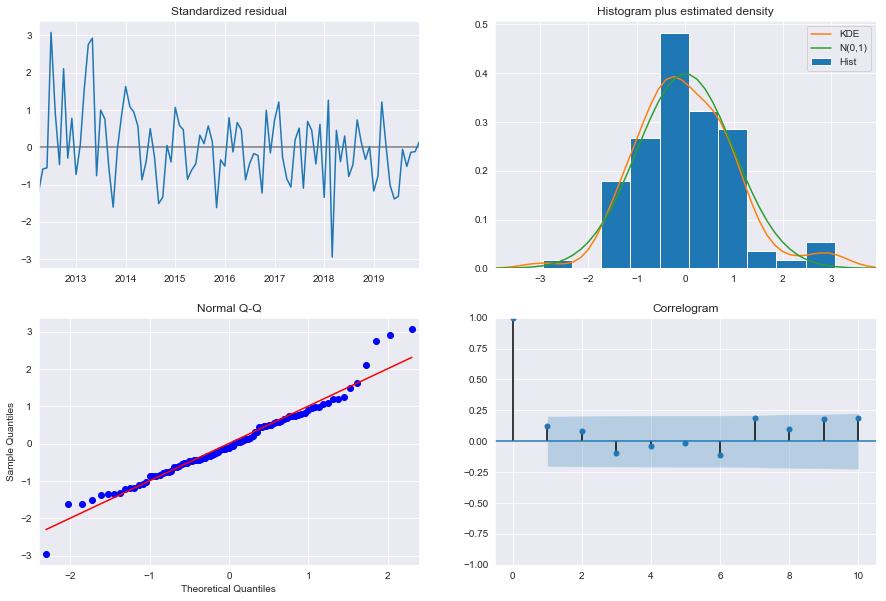

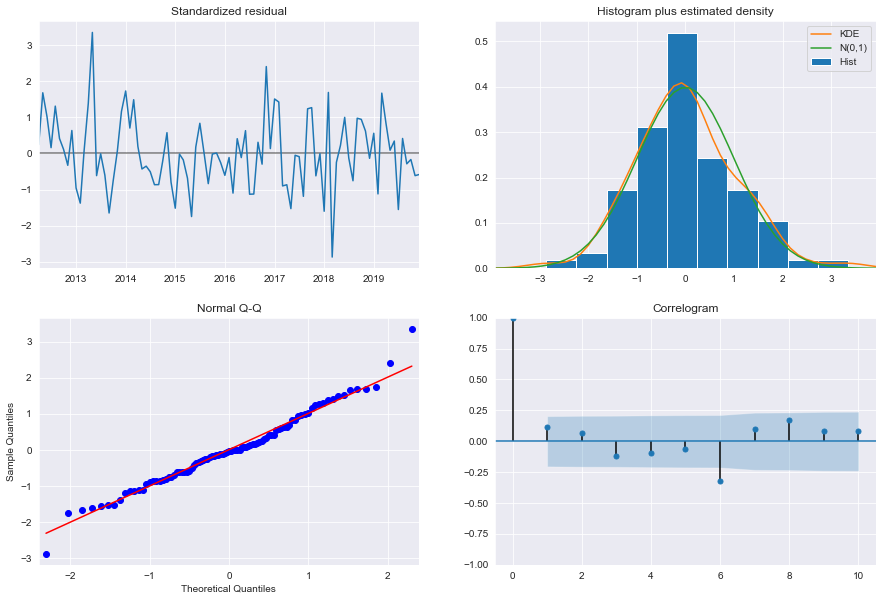

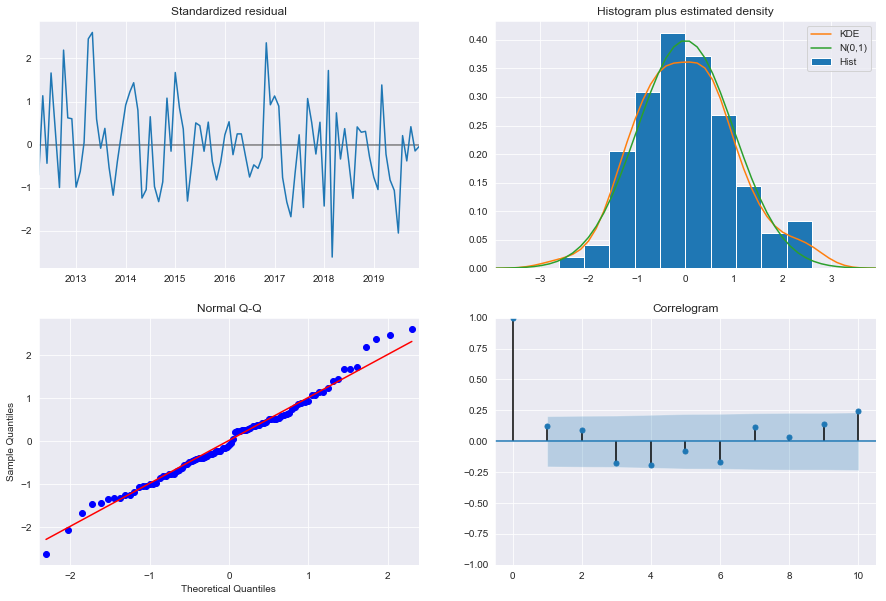

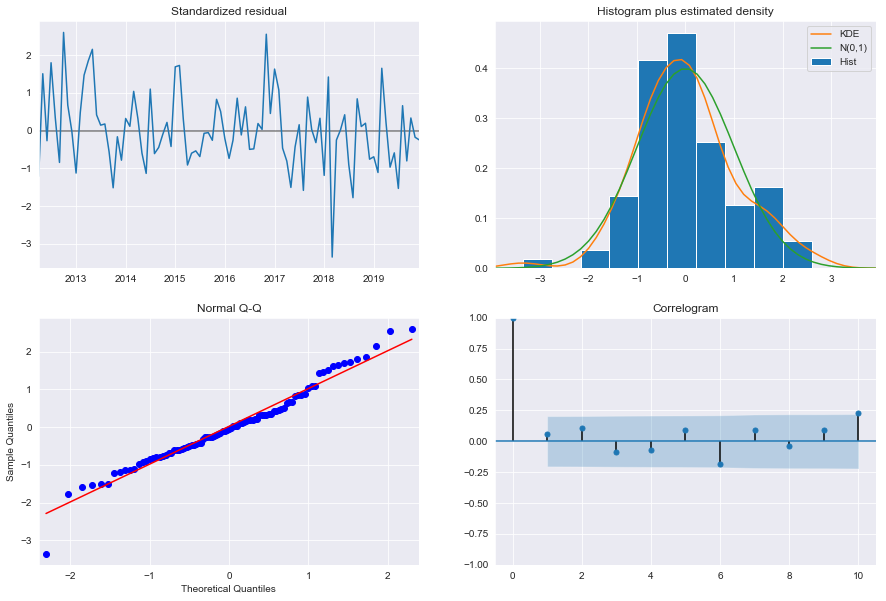

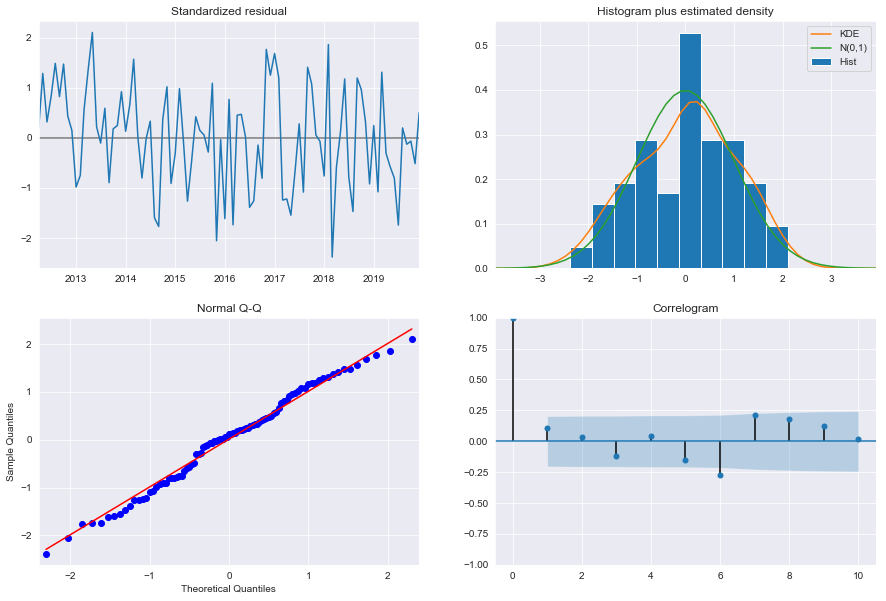

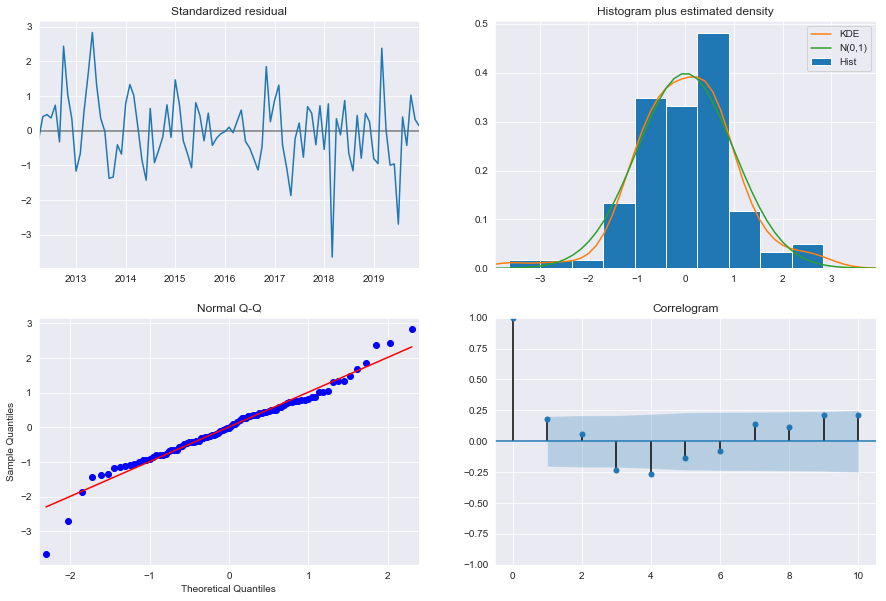

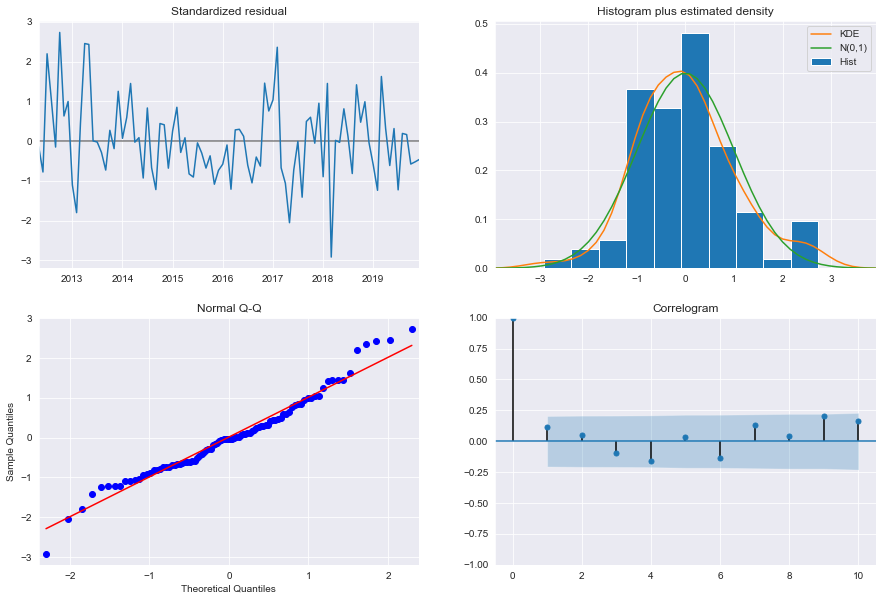

In [37]:
for x in top_five:
    print(f'\nZipcode: \t{x[0]}')
    display(x[2].summary())
    x[2].plot_diagnostics(figsize=(15,10));

# Step 5: Interpreting Results

Before we can interpret the results, we must first view them. Let's print the relevant metrics and graph the top five "best" models.

Zipcode:				20024
Root Mean Squared Error of forecast:	8272.316
Parker Confidence Score:		0.8438
Model 2-yr expected ROI rate:		24.61%


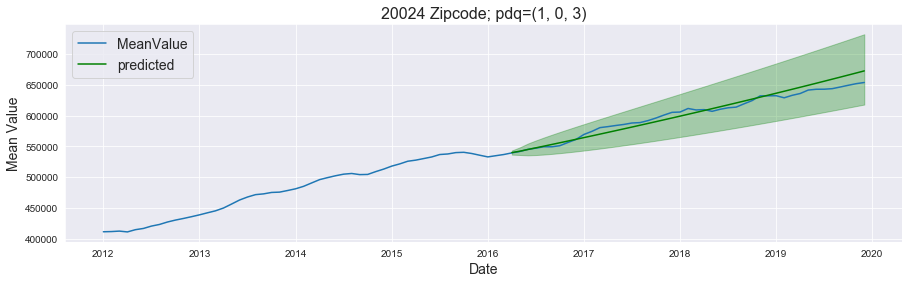

Zipcode:				20001
Root Mean Squared Error of forecast:	30358.985
Parker Confidence Score:		0.8189
Model 2-yr expected ROI rate:		19.95%


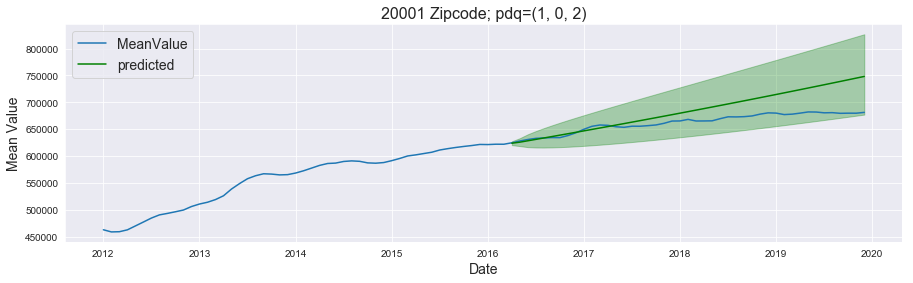

Zipcode:				20003
Root Mean Squared Error of forecast:	23868.792
Parker Confidence Score:		0.8285
Model 2-yr expected ROI rate:		17.82%


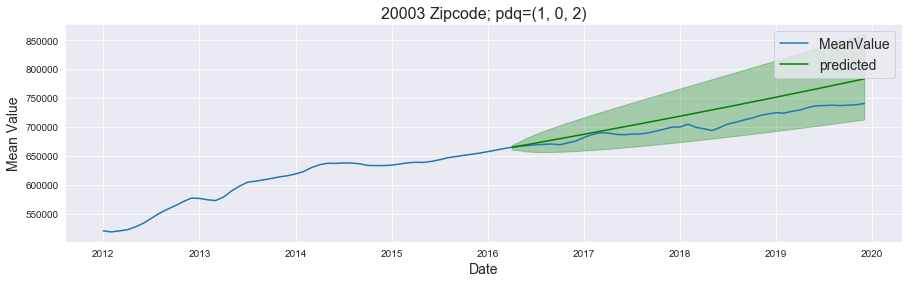

Zipcode:				20010
Root Mean Squared Error of forecast:	18456.457
Parker Confidence Score:		0.8157
Model 2-yr expected ROI rate:		16.3%


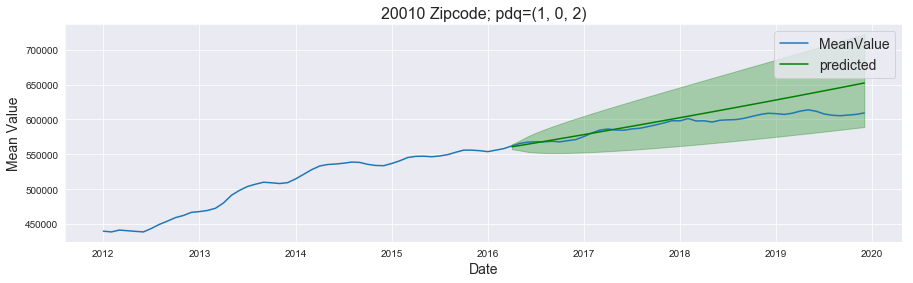

Zipcode:				20015
Root Mean Squared Error of forecast:	9047.283
Parker Confidence Score:		0.8432
Model 2-yr expected ROI rate:		12.63%


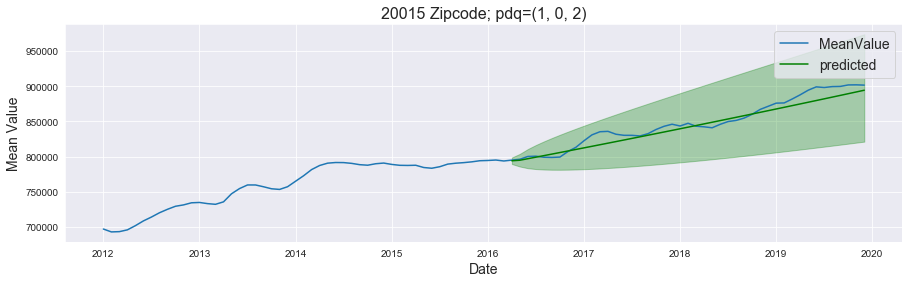

Zipcode:				20009
Root Mean Squared Error of forecast:	14952.882
Parker Confidence Score:		0.841
Model 2-yr expected ROI rate:		11.76%


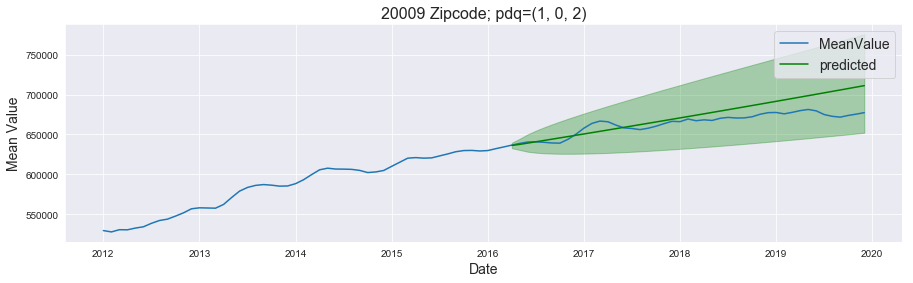

Zipcode:				20005
Root Mean Squared Error of forecast:	15341.208
Parker Confidence Score:		0.8403
Model 2-yr expected ROI rate:		11.43%


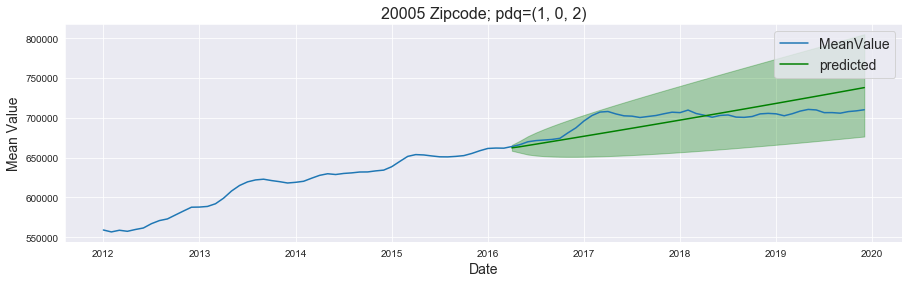

Zipcode:				20007
Root Mean Squared Error of forecast:	8648.966
Parker Confidence Score:		0.8596
Model 2-yr expected ROI rate:		11.4%


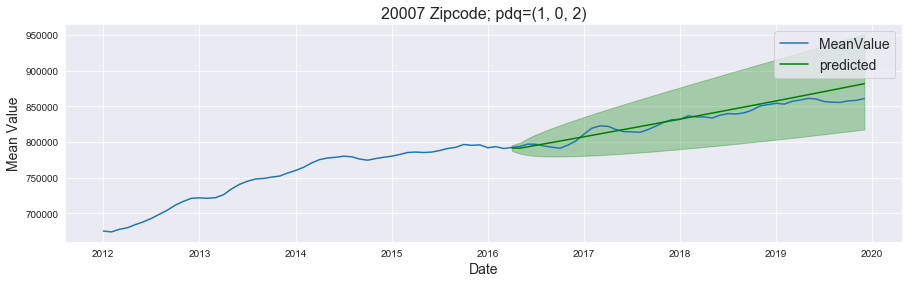

Zipcode:				20036
Root Mean Squared Error of forecast:	17008.475
Parker Confidence Score:		0.8261
Model 2-yr expected ROI rate:		9.75%


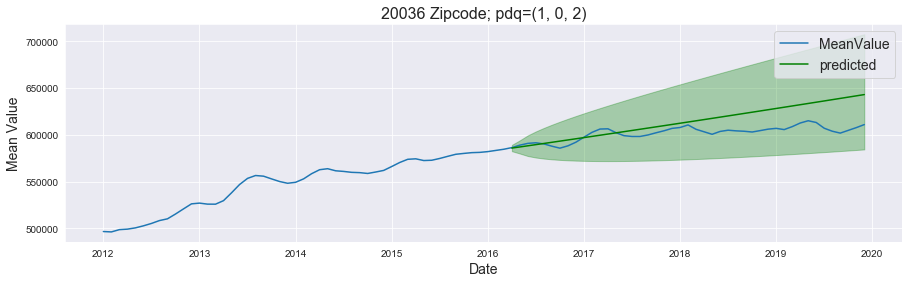

Zipcode:				20016
Root Mean Squared Error of forecast:	3781.792
Parker Confidence Score:		0.8967
Model 2-yr expected ROI rate:		9.64%


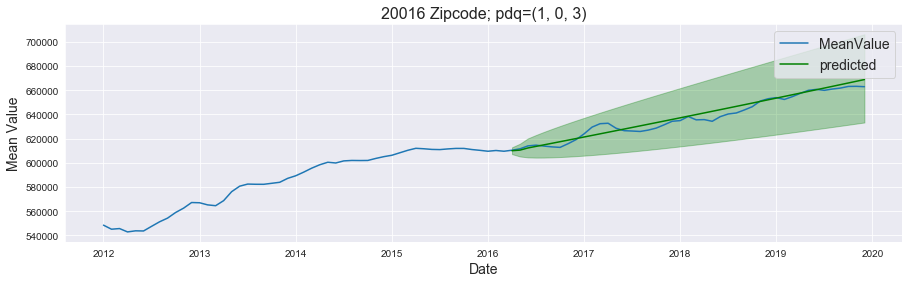

In [41]:
for x in top_five:
    print(f'Zipcode:\t\t\t\t{x[0]}')
    print(f'Root Mean Squared Error of forecast:\t{round(x[3], 3)}')
    print(f'Parker Confidence Score:\t\t{x[-1]}')
    print(f'Model 2-yr expected ROI rate:\t\t{np.round(x[-2]*100, 2)}%')
    prediction = x[2].get_prediction(start=pd.to_datetime('2016-04'), dynamic=True)
    pred_conf = prediction.conf_int()
    
    # Get the Real and predicted values
    df_truth = np.exp(DC_log[x[0]]['2016-04':])
    df_forecasted = np.exp(prediction.predicted_mean)
    
    # Plot observed & predicted values with confidence interval
    plot_predictions(DC_log[x[0]], x[0], prediction, pred_conf, x[1])

As you can see, all five models have a Parker Confidence Score (PCS) of at least .8. This suggests that our models for these zipcodes are quite accurate and will continue to be so further into the future than the best available models for other zipcodes. The purpose here was to cut down on risk caused by volatility. 

Furthermore, the root mean squared errors for all five are relatively low, with none greater than $20,000. 

Perhaps most importantly, the 2-year expected return on investment (ROI) rate for all five models ranges from .19-.35, a pretty nice profit!

### Looking to the Future

Now that we are satisfied with our models, let's look to the future and see what the next two years might bring.

Zipcode:	20024
Minimum ROI:	5.69%
Maximum ROI:	19.42%
Expected ROI:	12.34%


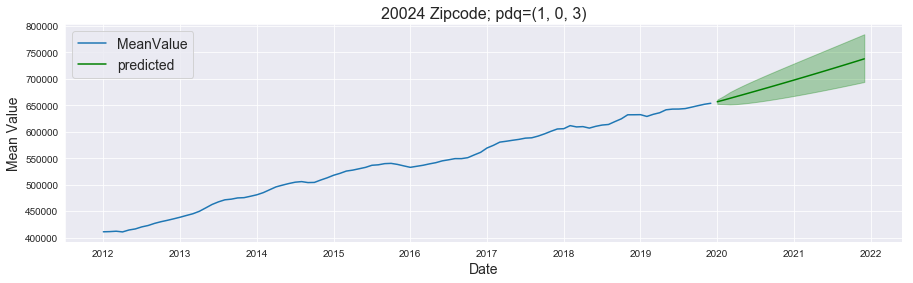

Zipcode:	20001
Minimum ROI:	2.41%
Maximum ROI:	18.19%
Expected ROI:	10.02%


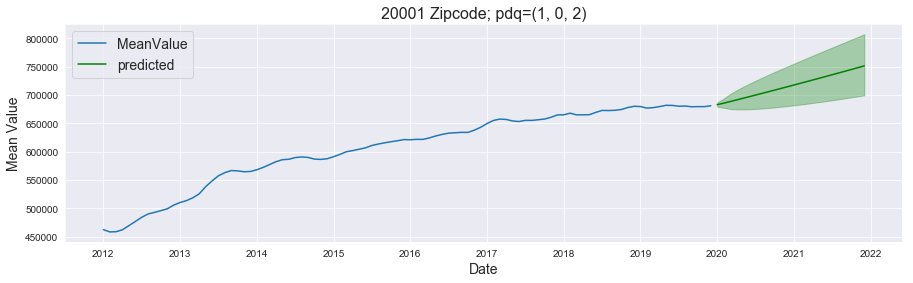

Zipcode:	20003
Minimum ROI:	1.92%
Maximum ROI:	16.68%
Expected ROI:	9.05%


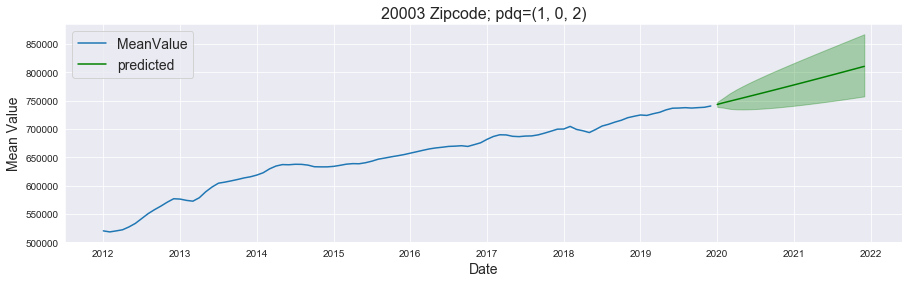

Zipcode:	20010
Minimum ROI:	0.65%
Maximum ROI:	16.52%
Expected ROI:	8.29%


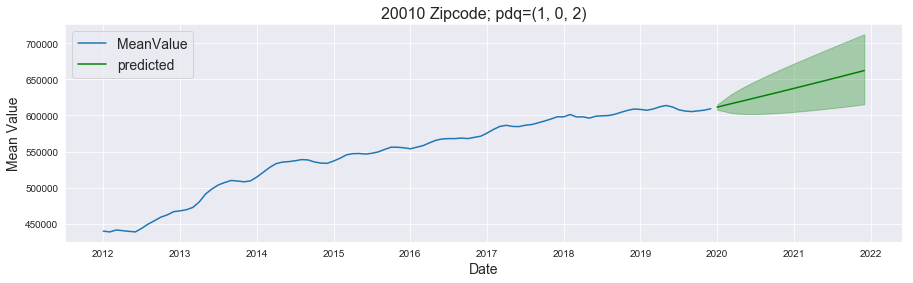

Zipcode:	20015
Minimum ROI:	0.13%
Maximum ROI:	13.2%
Expected ROI:	6.46%


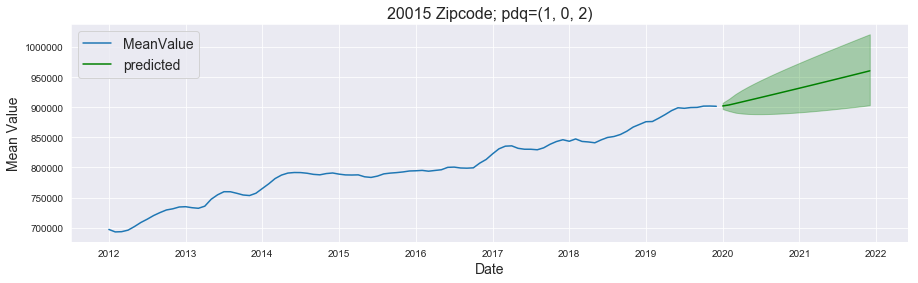

Zipcode:	20009
Minimum ROI:	-0.39%
Maximum ROI:	12.83%
Expected ROI:	6.02%


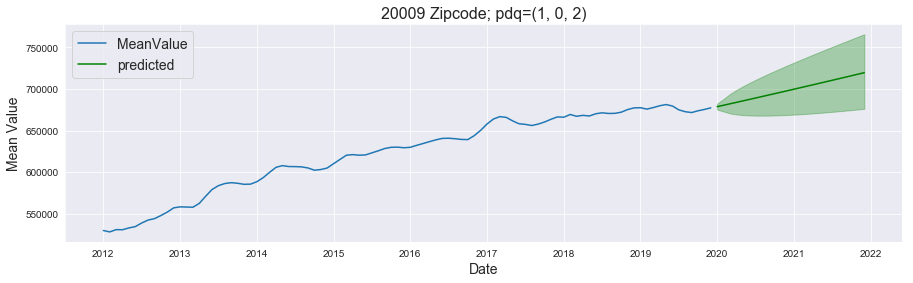

Zipcode:	20005
Minimum ROI:	-0.6%
Maximum ROI:	12.66%
Expected ROI:	5.82%


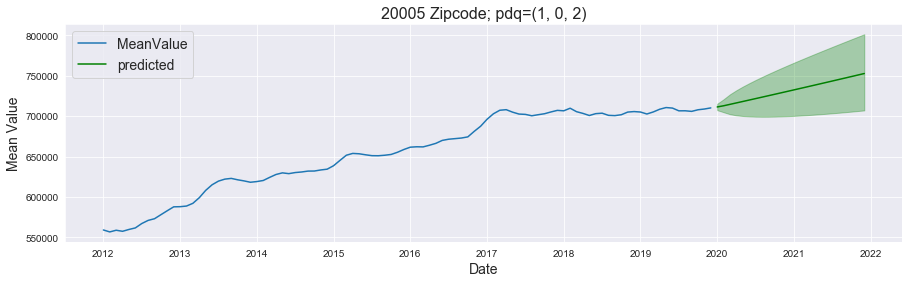

Zipcode:	20007
Minimum ROI:	0.45%
Maximum ROI:	12.0%
Expected ROI:	6.07%


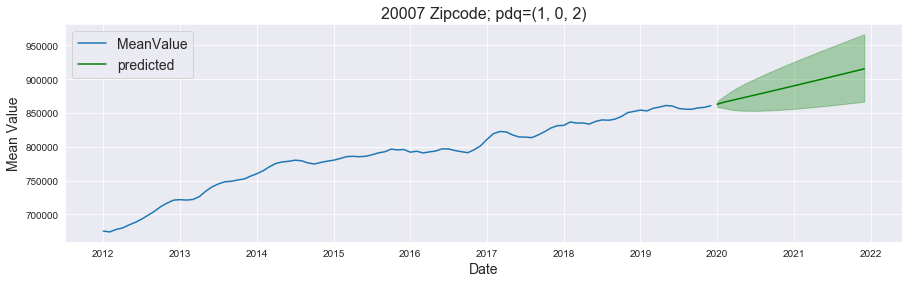

Zipcode:	20036
Minimum ROI:	-1.95%
Maximum ROI:	12.5%
Expected ROI:	5.03%


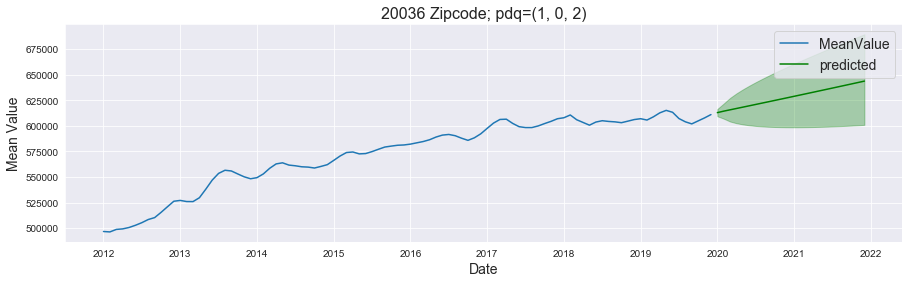

Zipcode:	20016
Minimum ROI:	0.93%
Maximum ROI:	9.23%
Expected ROI:	5.0%


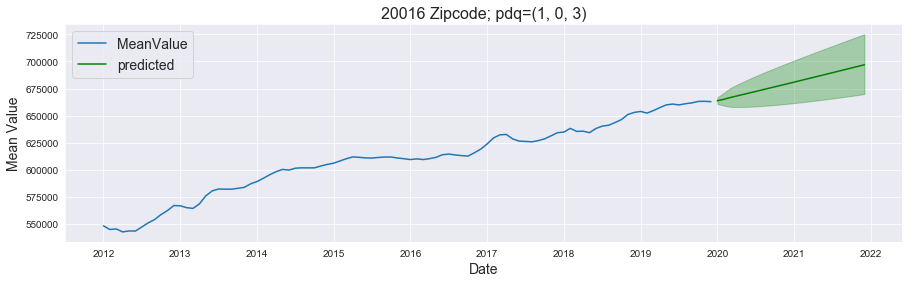

In [39]:
for x in top_five:
    print(f"Zipcode:\t{x[0]}")

    prediction = x[2].get_forecast(steps=24)
    pred_conf = prediction.conf_int()
    pr_con_exp = np.exp(pred_conf)
    
    # Get the Real and predicted values
    df_truth = np.exp(DC_log[x[0]]['2012':])
    df_forecasted = np.exp(prediction.predicted_mean)
    
    # Calculate various ROI rates:
    minROI = np.round(expected_roi(df_forecasted[0], pr_con_exp['lower MeanValue'][-1]),4)
    maxROI = np.round(expected_roi(df_forecasted[0], pr_con_exp['upper MeanValue'][-1]),4)
    eROI = np.round(expected_roi(df_forecasted[0], df_forecasted[-1]),4)
    print(f'Minimum ROI:\t{np.round(minROI*100, 2)}%')
    print(f'Maximum ROI:\t{np.round(maxROI*100, 2)}%')
    print(f"Expected ROI:\t{np.round(eROI*100, 2)}%")
    
    # Plot observed & predicted values with confidence interval
    plot_predictions(DC_log[x[0]], x[0], prediction, pred_conf, x[1])